In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import requests 
from bs4 import BeautifulSoup
import json
from highlight_text import ax_text, fig_text
import matplotlib as mpl
from mplsoccer.pitch import Pitch


pd.set_option("display.max_rows", None, "display.max_columns", None)
background = "#463F3A"
text_color = 'w'
primary = '#C8102E'
secondary = 'lightblue'
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

In [59]:
#scrapes a single game's shots, allow users to enter a base url
base_url = 'https://understat.com/match/'
match = str(input('Please enter the match id: '))
url = base_url+match

Please enter the match id: 14665


In [60]:
#Use requests to get the webpage and BeautifulSoup to parse the page
res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

In [61]:
#get only the shotsData
strings = scripts[1].string

In [62]:
# strip unnecessary symbols and get only JSON data 
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

#convert string to json format
data = json.loads(json_data)

In [63]:
#Create Dataframe
x_under = []
y_under = []
min_under = []
result_under = []
xG_under = []
player_under = []
team_under = []
dataa = data['a']
datah = data['h']
names = ['x','y','minute','team','xG','player','result']

for index in range(len(datah)):
    for key in datah[index]:
        if key == 'X':
            x_under.append(datah[index][key])
        if key == 'Y':
            y_under.append(datah[index][key])
        if key == 'minute':
            min_under.append(datah[index][key])
        if key == 'h_team':
            team_under.append(datah[index][key])
        if key == 'xG':
            xG_under.append(datah[index][key])
        if key == 'player':
            player_under.append(datah[index][key])
        if key == 'result':
            result_under.append(datah[index][key])
            
for index in range(len(dataa)):
    for key in dataa[index]:
        if key == 'X':
            x_under.append(1 - float(dataa[index][key]))
        if key == 'Y':
            y_under.append(1 - float(dataa[index][key]))
        if key == 'minute':
            min_under.append(dataa[index][key])
        if key == 'a_team':
            team_under.append(dataa[index][key])
        if key == 'xG':
            xG_under.append(dataa[index][key])
        if key == 'player':
            player_under.append(dataa[index][key])
        if key == 'result':
            result_under.append(dataa[index][key])

In [64]:
df = pd.DataFrame([x_under,y_under,min_under,team_under,xG_under,player_under,result_under],index=names)
df = df.T

df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])
df['xG'] = pd.to_numeric(df['xG'])
df['minute'] = pd.to_numeric(df['minute'])

df['x'] = df['x']*100
df['y'] = df['y']*100


df['xx'] = df['y']
df['yy'] = df['x']

df['x'] = df['xx']
df['y'] = df['yy']

df['x'] = df['x']*.8
df['y'] = df['y']*1.2

hteam = df['team'].iloc[0]
ateam = df['team'].iloc[-1]

In [65]:
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

for x in range(len(df['xG'])):
    if df['team'][x] == ateam:
        a_xG.append(df['xG'][x])
        a_min.append(df['minute'][x])
    if df['team'][x] == hteam:
        h_xG.append(df['xG'][x])
        h_min.append(df['minute'][x])
    
def nums_cumulative_sum(nums_list):
  return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

acum = nums_cumulative_sum(a_xG)
hcum = nums_cumulative_sum(h_xG)
alast = round(acum[-1],2)
hlast = round(hcum[-1],2)

In [66]:
def plotHomeShotMap():
    for x in range(len(df['x'])):
        if df['team'][x] == hteam:
            if df['result'][x] == 'Goal': 
                plt.scatter(df['x'][x],df['y'][x], color = '#74c69d',s=df['xG'][x]*500,edgecolor='white',linewidth=2,alpha=.7)
            else:
                plt.scatter(df['x'][x],df['y'][x], color = '#ff4d4d',s=df['xG'][x]*500,edgecolor='white',marker='X',alpha=.7)

def plotAwayShotMap():
    for x in range(len(df['x'])):
        if df['team'][x] == ateam:
            if df['result'][x] == 'Goal': 
                plt.scatter(df['x'][x],df['y'][x], color = '#74c69d',s=df['xG'][x]*500,edgecolor='white',linewidth=2,alpha=.7)       
            else:
                plt.scatter(df['x'][x],df['y'][x], color = '#ff4d4d',s=df['xG'][x]*500,edgecolor='white',marker='X',alpha=.7)

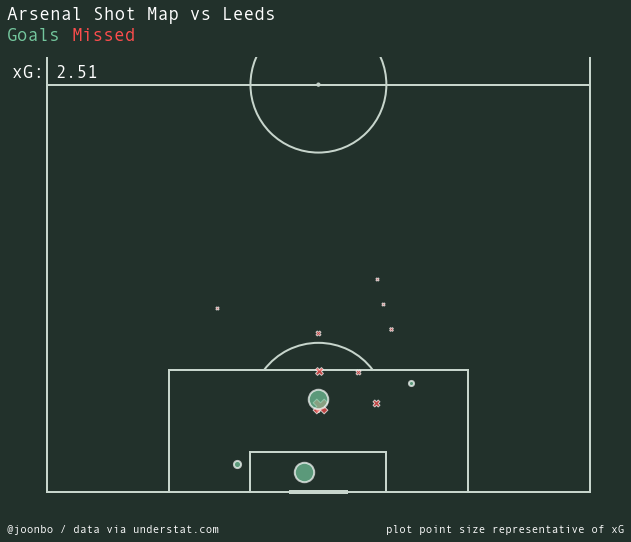

In [67]:
fig, ax = plt.subplots(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

#The statsbomb pitch from mplsoccer
pitch = Pitch(pitch_type='statsbomb', orientation='vertical',
              pitch_color='#22312b', line_color='#c7d5cc', figsize=(13, 8),
              constrained_layout=False, tight_layout=True, view='half')

pitch.draw(ax=ax)
plt.gca().invert_yaxis()

plotHomeShotMap()

s = hteam + " Shot Map vs " + ateam + " \n<Goals> <Missed>" 
fig_text(s=s,
         x=.18,y=.9,
         highlight_weights=['bold'],
         fontsize=18,
         fontfamily='Andale Mono',
         color=text_color,
         highlight_colors=['#74c69d','#ff4d4d'])

s1 = 'xG: <{}>'
fig_text(s=s1.format(hlast),
         x=.185,y=.84,
         highlight_weights=['bold'],
         fontsize=18,
         fontfamily='Andale Mono',
         color=text_color,
         highlight_colors = [text_color])

fig_text(.18,.1,"@joonbo / data via understat.com",fontstyle='italic',fontsize=11,fontfamily='Andale Mono',color=text_color)
fig_text(.585,.1,'plot point size representative of xG',fontstyle='italic',fontsize=11,fontfamily='Andale Mono',color=text_color)

plt.savefig(hteam.replace(" ", "")+'shotmap.png',dpi=300,bbox_inches = 'tight',facecolor=background)

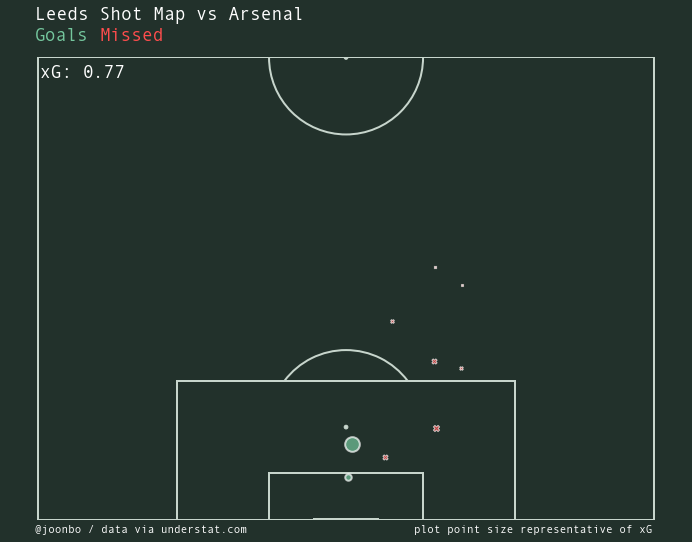

In [68]:
fig, ax = plt.subplots(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

pitch = Pitch(pitch_type='statsbomb', orientation='vertical',
              pitch_color='#22312b', line_color='#c7d5cc', figsize=(13, 8),
              constrained_layout=False, tight_layout=True)

pitch.draw(ax=ax)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

plt.ylim(0,60)

plotAwayShotMap()


s = ateam + " Shot Map vs " + hteam + " \n<Goals> <Missed>" 
fig_text(s=s,
         x=.18,y=.9,
         highlight_weights=['bold'],
         fontsize=18,
         fontfamily='Andale Mono',
         color=text_color,
         highlight_colors=['#74c69d','#ff4d4d'])

s1 = 'xG: <{}>'
fig_text(s=s1.format(alast),
         x=.185,y=.84,
         highlight_weights=['bold'],
         fontsize=18,
         fontfamily='Andale Mono',
         color=text_color,
         highlight_colors = [text_color])

fig_text(.18,.1,"@joonbo / data via understat.com",fontstyle='italic',fontsize=11,fontfamily='Andale Mono',color=text_color)
fig_text(.585,.1,'plot point size representative of xG',fontstyle='italic',fontsize=11,fontfamily='Andale Mono',color=text_color)

plt.savefig(ateam.replace(" ", "")+'shotmap.png',dpi=300,bbox_inches = 'tight',facecolor=background)